In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")

# Extracción y transformación inicial de datos

### 0. Funciones a utilizar

In [45]:
dict_meses = {
    "Ene": "01",
    "Feb": "02",
    "Mar": "03",
    "Abr": "04",
    "May": "05",
    "Jun": "06",
    "Jul": "07",
    "Ago": "08",
    "Sep": "09",
    "Oct": "10",
    "Nov": "11",
    "Dic": "12",
}

In [47]:
def graficar_serie_temporal(df, col_x, col_y, y_label):
    _ = plt.figure(figsize=(16,6))
    _ = plt.plot(df[col_x],
                 df[col_y], 
                 marker='.', 
                 linestyle='None')

    _ = plt.ticklabel_format(style='plain', axis='y')
    _ = plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    _ = plt.xlabel("Año")
    _ = plt.ylabel(y_label)
    _ = plt.xticks(rotation=45)
    _ = plt.grid()
    _ = plt.show()


def graficar_por_anio(df, col_x, col_y, y_label):
    
    _ = plt.figure(figsize=(16,6))
    _ = plt.plot(df[col_x],
                 df[col_y], 
                 marker='.', 
                 linestyle='None')

    _ = plt.ticklabel_format(style='plain', axis='y')
    _ = plt.xticks(range(df[col_x].min()-1, df[col_x].max()+1, 1))
    _ = plt.xlabel("Año")
    _ = plt.ylabel(y_label)
    _ = plt.xticks(rotation=45)
    _ = plt.grid()
    _ = plt.show()


def boxplot_filtrado(df, col_fecha, col_valor, anios, whis=1.5, por_año=True):
    """
    Dibuja un boxplot de los valores de un DataFrame filtrado por años específicos.

    Parámetros:
    - df: DataFrame con los datos
    - col_fecha: nombre de la columna con las fechas (formato datetime)
    - col_valor: nombre de la columna con los valores numéricos
    - años: lista de años a incluir, ej: [2020, 2025]
    - whis: float o [inferior, superior], tolerancia para los bigotes
    - por_año: si True, genera un boxplot separado por año en el eje x
               si False, un único boxplot con todos los datos juntos
    """
    df = df.copy()
    df['anio'] = df[col_fecha].dt.year
    df_filtrado = df[df['anio'].isin(anios)]
    
    plt.figure(figsize=(12, 6))
    if por_año:
        sns.boxplot(
            x=col_valor, y='anio', data=df_filtrado,
            whis=whis, orient='h'
        )
        plt.xlabel("Año")
    else:
        sns.boxplot(
            y='anio', data=df_filtrado,
            whis=whis, orient='h'
        )
    plt.ylabel(col_valor)
    plt.title(f"Boxplot para los años {anios}")
    plt.show()


def ajustar_atipicos_por_anio(df, columna_valor, anios, columna_fecha="Fecha"):
    """
    Ajusta los valores atípicos de una columna numérica en un DataFrame por año usando interpolación lineal.
    
    Parámetros:
    - df: DataFrame con los datos.
    - columna_valor: Nombre de la columna con los valores numéricos a ajustar.
    - anios: Lista de años a procesar.
    - columna_fecha: Nombre de la columna de fechas. Por defecto es "Fecha"

    Retorna:
    - DataFrame con los valores atípicos ajustados.
    """

    # Copia del dataframe para no modificar el original
    df = df.copy() 
    
    # Convertir a datetime
    df[columna_fecha] = pd.to_datetime(df[columna_fecha])

    for anio in anios:
        # Filtrar por año
        df_anio = df[df[columna_fecha].dt.year == anio]

        # Calcular IQR
        q1, q3 = np.percentile(df_anio[columna_valor].dropna(), [25, 75])
        iqr = q3 - q1
        lim_inf = q1 - 1.4 * iqr
        lim_sup = q3 + 1.5 * iqr

        # Reemplazar atípicos con nan para después interpolar
        df.loc[(df[columna_fecha].dt.year == anio) & 
               ((df[columna_valor] < lim_inf) | (df[columna_valor] > lim_sup)), 
               columna_valor] = np.nan

    # Interpolar
    df[columna_valor] = df[columna_valor].interpolate()

    return df

def construir_columna_fecha(df):
    """
    Esta función crea una nueva columna de fecha en un DataFrame dado. 
    Si el DataFrame contiene una columna relacionada con el mes, se utiliza 
    para construir una fecha en formato 'Año/Mes'. Si no hay columna de mes, 
    se asigna el primer día del año ('Año/01/01'). 
    
    - Convierte la columna 'Año' a tipo string.
    - Si la columna de mes está en formato de texto, la mapea a valores numéricos.
    - Si la columna de mes es un número entero, la convierte a string.
    - Finalmente, combina 'Año' y 'Mes' en una columna 'Fecha' con formato datetime.
    """
    
    tiene_mes = False
    cols_df = df.columns.values

    # Verificar si el dataframe tiene una columna de mes
    for col in cols_df:
        if "mes" in col.lower():
            col_mes = col
            tiene_mes = True
    
    # Transformar el año a cadena de texto para posteriormente concatenarlo
    # y transformarlo a datetime
    df["Año"] = df["Año"].astype("int")
    df["Año"] = df["Año"].astype("string")

    # En caso de que tenga mes
    if tiene_mes:
        if pd.api.types.is_string_dtype(df[col_mes]) or df[col_mes].dtype == "string" or df[col_mes].dtype == "object":
            df[col_mes] = df[col_mes].map(dict_meses)

        if df[col_mes].dtype == "int64" or df[col_mes].dtype == "int32":
            df[col_mes] = df[col_mes].astype("string")
            
        df["Fecha"] = df["Año"] + "/" + df[col_mes]
        df["Fecha"] = pd.to_datetime(df["Fecha"], yearfirst=True)
    else:
        df["Fecha"] = df["Año"] + "/01/01"
        df["Fecha"] = pd.to_datetime(df["Fecha"], yearfirst=True)


def desagregar_demanda_mensual(df_mensual, df_anual, nombre_col_valor, acumulada=False):
    """
    Esta función desagrega los valores de demanda anual en valores mensuales utilizando 
    datos históricos de un DataFrame mensual como referencia para calcular un patrón de distribución.

    Parámetros:
    - df_mensual: DataFrame con valores mensuales de referencia.
    - df_anual: DataFrame con valores anuales a desagregar.
    - nombre_col_valor: Nombre de la columna que contiene los valores de demanda.
    - acumulada: Booleano que indica si los valores anuales son acumulados (True) 
      o representan totales anuales no acumulados (False).

    Proceso:
    - Convierte la columna 'Fecha' a datetime y extrae mes y año.
    - Si los valores no son acumulados, calcula un patrón mensual promedio basado en 
      los porcentajes mensuales sobre la demanda anual.
    - Si los valores son acumulados, utiliza el valor de diciembre como referencia 
      para calcular un patrón de distribución.
    - Distribuye los valores anuales en valores mensuales utilizando el patrón promedio.
    - Ajusta posibles diferencias debido a redondeos para mantener la suma total anual.

    Retorna:
    - Un DataFrame con los valores desagregados en formato [Año, Mes, Valor].
    """

    # Asegurarse que la columna 'Fecha' sea datetime y extraer el mes y año
    df_mensual = df_mensual.copy()
    df_mensual['Fecha'] = pd.to_datetime(df_mensual['Fecha'])
    df_mensual['Mes'] = df_mensual['Fecha'].dt.month
    df_mensual['Año'] = df_mensual['Fecha'].dt.year

    # Lista de meses (1 a 12)
    meses = list(range(1, 13))
    datos_desagregados = []

    if not acumulada:
        # Caso en el cual los valores no son acumulados
        # El porcentaje SI debe ser repartido

        # Calcular la demanda total por año en el dataframe mensual y el porcentaje mensual
        df_mensual['valor_anual'] = df_mensual.groupby('Año')[nombre_col_valor].transform('sum')

        # Calcular el porcentaje mensual sobre cada mes
        df_mensual['porcentaje_mensual'] = df_mensual[nombre_col_valor] / df_mensual['valor_anual']
        
        # Calcular el patrón mensual promedio usando todos los años disponibles en el dataframe mensual
        patron_mensual = df_mensual.groupby('Mes')['porcentaje_mensual'].median()
        print(patron_mensual)
        
        # Iterar sobre cada año en el DataFrame anual
        for _, row in df_anual.iterrows():
            año = row['Año']
            total_anual = row[nombre_col_valor]
            
            # Estimar los valores mensuales usando el patrón promedio multiplicado por el total anual
            # Se toma el patrón para cada mes
            valores_mensuales = patron_mensual.loc[meses] * total_anual
            
            # Ajuste para que la suma de los 12 meses sea exactamente igual al total anual (por posibles redondeos)
            diferencia = total_anual - valores_mensuales.sum()
            ajuste = diferencia / 12  # Distribución uniforme del ajuste
            valores_mensuales += ajuste
            
            for mes, demanda_mes in zip(meses, valores_mensuales):
                datos_desagregados.append([año, mes, demanda_mes])


    else:
        # Caso en el cual los valores son acumulados
        # El porcentaje en este caso NO debe ser repartido

        # Iterar sobre cada fila del dataframe
        for index, row in df_mensual.iterrows():
            if row['Mes'] == 1 or row['Mes'] == 12:
                valor_mes_12 = df_mensual[(df_mensual['Mes']==12) & (df_mensual['Año']==row['Año'])][nombre_col_valor].values[0]

            # Asignar el valor del mes de diciembre de su año correspondiente
            # para comenzar a desagregar    
            df_mensual.loc[index, 'valor_mes_12'] = valor_mes_12

        # Calcular el porcentaje mensual sobre el acumulado del mes de diciembre de cada año
        df_mensual['porcentaje_mensual_mes12'] = df_mensual[nombre_col_valor] / df_mensual['valor_mes_12']

        # Calcular el patrón mensual promedio sobre el acumulado del mes de diciembre
        patron_mensual_ac = df_mensual.groupby('Mes')['porcentaje_mensual_mes12'].median()

        # Iterar sobre cada año en el DataFrame anual
        for _, row in df_anual.iterrows():
            año = row['Año']
            total_anual = row[nombre_col_valor]
            
            # Estimar los valores mensuales usando el patrón promedio multiplicado por el total anual
            # Se toma el patrón para cada mes
            valores_mensuales = patron_mensual_ac.loc[meses] * total_anual
            
            for mes, demanda_mes in zip(meses, valores_mensuales):
                datos_desagregados.append([año, mes, demanda_mes])
    
    # Crear DataFrame de salida
    df_desagregado = pd.DataFrame(datos_desagregados, columns=['Año', 'Mes', nombre_col_valor])
    return df_desagregado


In [4]:
def desagregar_demanda_mensual(df_mensual, df_anual, nombre_col_valor, acumulada=False):
    """
    Esta función desagrega los valores de demanda anual en valores mensuales utilizando 
    datos históricos de un DataFrame mensual como referencia para calcular un patrón de distribución.

    Parámetros:
    - df_mensual: DataFrame con valores mensuales de referencia.
    - df_anual: DataFrame con valores anuales a desagregar.
    - nombre_col_valor: Nombre de la columna que contiene los valores de demanda.
    - acumulada: Booleano que indica si los valores anuales son acumulados (True) 
      o representan totales anuales no acumulados (False).

    Proceso:
    - Convierte la columna 'Fecha' a datetime y extrae mes y año.
    - Si los valores no son acumulados, calcula un patrón mensual promedio basado en 
      los porcentajes mensuales sobre la demanda anual.
    - Si los valores son acumulados, utiliza el valor de diciembre como referencia 
      para calcular un patrón de distribución.
    - Distribuye los valores anuales en valores mensuales utilizando el patrón promedio.
    - Ajusta posibles diferencias debido a redondeos para mantener la suma total anual.

    Retorna:
    - Un DataFrame con los valores desagregados en formato [Año, Mes, Valor].
    """

    # Asegurarse que la columna 'Fecha' sea datetime y extraer el mes y año
    df_mensual = df_mensual.copy()
    df_mensual['Fecha'] = pd.to_datetime(df_mensual['Fecha'])
    df_mensual['Mes'] = df_mensual['Fecha'].dt.month
    df_mensual['Año'] = df_mensual['Fecha'].dt.year

    # Lista de meses (1 a 12)
    meses = list(range(1, 13))
    datos_desagregados = []

    if not acumulada:
        # Caso en el cual los valores no son acumulados
        # El porcentaje SI debe ser repartido

        # Calcular la demanda total por año en el dataframe mensual y el porcentaje mensual
        df_mensual['valor_anual'] = df_mensual.groupby('Año')[nombre_col_valor].transform('sum')

        # Calcular el porcentaje mensual sobre cada mes
        df_mensual['porcentaje_mensual'] = df_mensual[nombre_col_valor] / df_mensual['valor_anual']
        
        # Calcular el patrón mensual promedio usando todos los años disponibles en el dataframe mensual
        patron_mensual = df_mensual.groupby('Mes')['porcentaje_mensual'].median()
        print(patron_mensual)
        
        # Iterar sobre cada año en el DataFrame anual
        for _, row in df_anual.iterrows():
            año = row['Año']
            total_anual = row[nombre_col_valor]
            
            # Estimar los valores mensuales usando el patrón promedio multiplicado por el total anual
            # Se toma el patrón para cada mes
            valores_mensuales = patron_mensual.loc[meses] * total_anual
            
            # Ajuste para que la suma de los 12 meses sea exactamente igual al total anual (por posibles redondeos)
            diferencia = total_anual - valores_mensuales.sum()
            ajuste = diferencia / 12  # Distribución uniforme del ajuste
            valores_mensuales += ajuste
            
            for mes, demanda_mes in zip(meses, valores_mensuales):
                datos_desagregados.append([año, mes, demanda_mes])


    else:
        # Caso en el cual los valores son acumulados
        # El porcentaje en este caso NO debe ser repartido

        meses = np.arange(1, 13)  # Meses de 1 a 12

        # Calcular el patrón de crecimiento mensual basado en datos históricos
        df_mensual['porcentaje_mensual_mes12'] = df_mensual[nombre_col_valor] / df_mensual.groupby('Año')[nombre_col_valor].transform('last')

        # Se usa la mediana de cada mes para evitar sesgos de valores atípicos
        patron_mensual_ac = df_mensual.groupby('Mes')['porcentaje_mensual_mes12'].median()
        patron_mensual_ac /= patron_mensual_ac.sum()  # Normalizamos a 1

        # Ordenar el dataframe anual por año
        df_anual = df_anual.sort_values('Año').reset_index(drop=True)

        # Inicializar diciembre del primer año conocido
        valor_diciembre_anterior = df_anual.loc[0, nombre_col_valor]

        # Iterar sobre los años a partir del segundo año
        for i in range(1, len(df_anual)):
            año_actual = df_anual.loc[i, 'Año']
            total_actual = df_anual.loc[i, nombre_col_valor]

            # Calcular el incremento anual
            incremento_anual = total_actual - valor_diciembre_anterior

            # Distribuir el crecimiento mensual acumulativo
            valores_mensuales = [valor_diciembre_anterior]  # Empezamos desde diciembre del año anterior
            for mes in meses[:-1]:  # Enero a noviembre
                nuevo_valor = valores_mensuales[-1] + (incremento_anual * patron_mensual_ac.loc[mes])
                valores_mensuales.append(nuevo_valor)

            # Último mes (diciembre) debe coincidir con el total anual
            valores_mensuales.append(total_actual)

            # Guardar datos desagregados
            for mes, demanda_mes in zip(meses, valores_mensuales):
                datos_desagregados.append([año_actual, mes, demanda_mes])

            # Actualizar diciembre como base para el próximo año
            valor_diciembre_anterior = total_actual


    # Crear DataFrame de salida
    df_desagregado = pd.DataFrame(datos_desagregados, columns=['Año', 'Mes', nombre_col_valor])
    
    if acumulada:
        # Desplazamiento de valores hacia atrás
        df_desagregado[nombre_col_valor] = df_desagregado[nombre_col_valor].shift(-1)
        
        # Debido a que se desplazó, rellenar el último valor nulo
        df_desagregado = df_desagregado.fillna(df_anual.iloc[-1][nombre_col_valor])
          
            
    return df_desagregado

### 1. Energía suministrada

In [48]:
path_archivo = r"../data/Resumen_datos.xlsx"
path_archivo = r"../data/Resumen de datos2.xlsx"

In [49]:
df_ener_suministrada = pd.read_excel(path_archivo, engine="openpyxl", sheet_name="Energia_Disponible_Distribuidor", skiprows=3)

df_ener_suministrada

,Meses,1975,1976,1977,1978,1979,1980,1981,1982,1983,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Ene,35864.1,41291.9,45837.9,54948.6,58608.7,66807.6,72174.9,75842.6,81066.5,...,3.454260e+05,3.511907e+05,3.568147e+05,3.644045e+05,359821.900,3.498157e+05,3.267862e+05,3.442080e+05,3.454797e+05,3.558419e+05
1,Feb,33732.0,40719.8,43512.8,50426.0,46469.8,64240.5,66857.6,70826.3,74922.1,...,3.119434e+05,3.296328e+05,3.216689e+05,3.280145e+05,328283.557,3.255867e+05,2.986310e+05,3.140945e+05,3.126086e+05,3.346871e+05
2,Mar,36944.6,42247.8,49649.3,56426.4,61112.3,69278.6,72428.5,81637.7,83540.4,...,3.508151e+05,3.494243e+05,3.669288e+05,3.702152e+05,351214.937,3.254619e+05,3.378085e+05,3.511023e+05,3.580310e+05,3.577740e+05
3,Abr,37317.7,41375.3,47155.9,55708.2,58462.5,66886.3,69932.5,77052.6,82867.9,...,3.398993e+05,3.379307e+05,3.445047e+05,3.574204e+05,342602.871,2.801613e+05,3.186668e+05,3.394375e+05,3.378790e+05,3.314213e+05
4,May,38220.5,43102.8,50216.5,57532.8,61630.5,70154.4,72824.6,79535.6,84869.0,...,3.485876e+05,3.485457e+05,3.608743e+05,3.729236e+05,351686.310,2.975676e+05,3.283241e+05,3.507199e+05,3.544125e+05,3.596623e+05
5,Jun,36754.3,42379.9,50633.1,57788.6,61278.8,69049.7,74047.3,78815.4,83215.6,...,3.444728e+05,3.422612e+05,3.504883e+05,3.627421e+05,340935.792,3.059671e+05,3.244600e+05,3.338565e+05,3.447638e+05,3.463361e+05
6,Jul,38956.7,42867.8,51535.4,57561.0,63531.4,70225.1,76135.8,81207.1,84375.5,...,3.552441e+05,3.485137e+05,3.544361e+05,3.673464e+05,361647.209,3.145237e+05,3.318410e+05,3.466548e+05,3.503011e+05,3.597219e+05
7,Ago,38071.9,41956.0,51161.6,57588.4,63379.3,68679.4,71874.0,77792.3,84043.7,...,3.480964e+05,3.487865e+05,3.526526e+05,3.487745e+05,356545.887,3.172629e+05,3.288914e+05,3.477557e+05,3.521270e+05,3.547919e+05
8,Sep,37855.0,40683.4,51736.0,56927.5,62145.2,67673.6,73928.7,77913.4,82223.7,...,3.511140e+05,3.429770e+05,3.484062e+05,3.587239e+05,344208.485,3.152537e+05,3.351169e+05,3.371584e+05,3.441180e+05,3.351150e+05
9,Oct,41082.0,44111.2,53793.5,58740.3,66412.2,72043.4,75438.6,80949.3,84383.8,...,3.627701e+05,3.559604e+05,3.629028e+05,3.539857e+05,348956.323,3.282737e+05,3.472520e+05,3.458930e+05,3.537625e+05,2.853747e+05


In [50]:
df_melted = df_ener_suministrada.melt(id_vars=['Meses'], var_name='Mes', value_name='Valor')
df_melted.columns = ["Mes", "Año", "Energía suministrada MWh"]

df_melted

,Mes,Año,Energía suministrada MWh
0,Ene,1975,3.586410e+04
1,Feb,1975,3.373200e+04
2,Mar,1975,3.694460e+04
3,Abr,1975,3.731770e+04
4,May,1975,3.822050e+04
...,...,...,...
645,Sep,2024,3.351150e+05
646,Oct,2024,2.853747e+05
647,Nov,2024,2.783762e+05
648,Dic,2024,3.339313e+05


In [51]:
df_melted["Mes"] = df_melted["Mes"].astype("string")
df_melted["Energía suministrada MWh"] = df_melted["Energía suministrada MWh"].astype("float")

In [52]:
df_max_valores_ener_suministrada = df_melted[df_melted["Mes"]=="TOTAL"].copy()
df_max_valores_ener_suministrada = df_max_valores_ener_suministrada[["Año", "Energía suministrada MWh"]].reset_index(drop=True)
df_max_valores_ener_suministrada.head(5)

,Año,Energía suministrada MWh
0,1975,455626.1
1,1976,509312.2
2,1977,599862.7
3,1978,678687.6
4,1979,731200.5


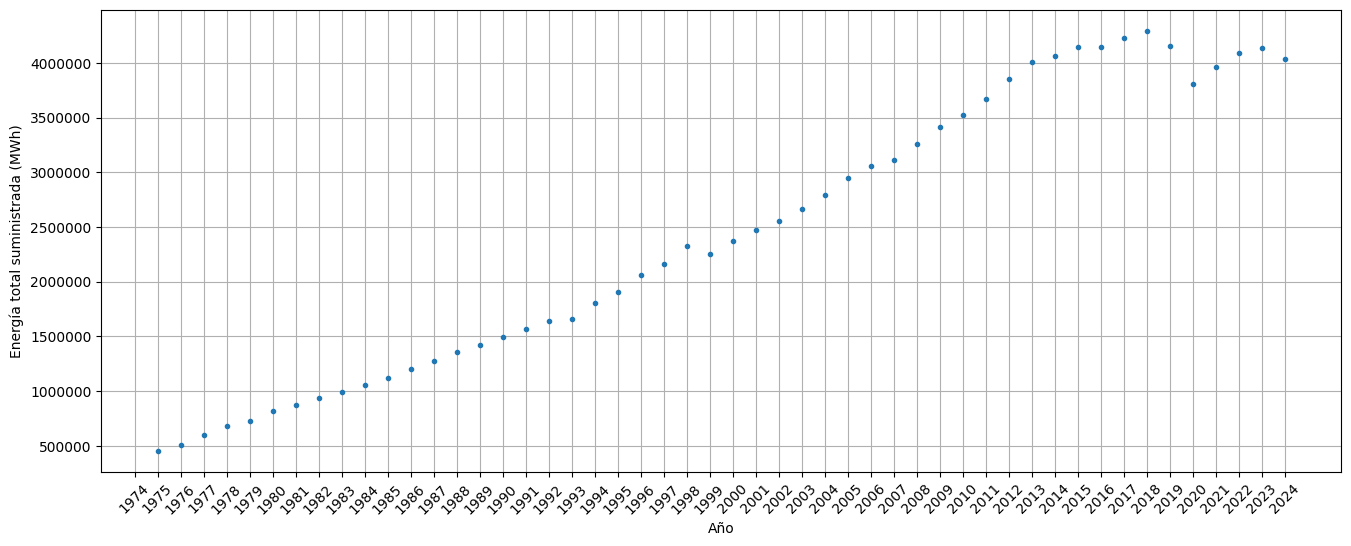

In [53]:
graficar_por_anio(df_max_valores_ener_suministrada, "Año", "Energía suministrada MWh", "Energía total suministrada (MWh)")

In [54]:
df_ener_suministrada = df_melted[df_melted["Mes"]!="TOTAL"].copy()
construir_columna_fecha(df_ener_suministrada)
df_ener_suministrada = df_ener_suministrada[["Fecha", "Energía suministrada MWh"]].reset_index(drop=True).sort_values(by="Fecha", ascending=True)

df_ener_suministrada.head(5)

,Fecha,Energía suministrada MWh
0,1975-01-01,35864.1
1,1975-02-01,33732.0
2,1975-03-01,36944.6
3,1975-04-01,37317.7
4,1975-05-01,38220.5


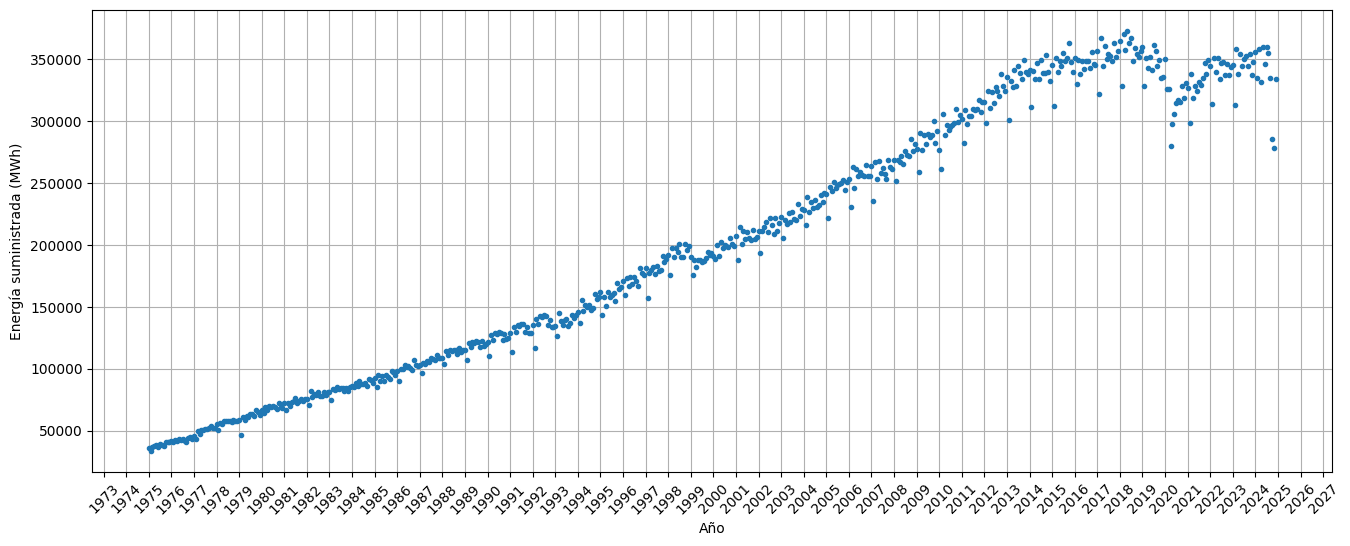

In [55]:
graficar_serie_temporal(df_ener_suministrada, "Fecha", "Energía suministrada MWh", "Energía suministrada (MWh)")

### Demanda de potencia SEQ

In [56]:
df_demanda_potencia = pd.read_excel(path_archivo, engine="openpyxl", sheet_name="Pot_max_coin", skiprows=2)
df_demanda_potencia

,Meses,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Ene,53.10,57.4,63.2,66.2,75.80,83.8,96.80,108.0,126.1,...,735.300000,694.730000,726.040000,750.927000,712.377086,702.894745,678.548840,690.004136,705.46,724.59
1,Feb,55.10,59.6,64.2,66.6,78.20,86.6,99.00,110.8,130.1,...,724.994223,720.540456,721.250000,747.099000,708.391322,706.280000,681.647672,689.980000,701.50,714.41
2,Mar,53.55,59.7,68.0,67.9,78.30,88.2,98.30,117.4,133.9,...,718.990000,702.710228,734.730000,754.876000,706.149448,702.863272,689.423000,697.359161,716.00,721.31
3,Abr,53.70,60.8,63.7,68.8,80.04,88.7,98.00,114.4,128.1,...,732.680000,697.557904,719.490000,746.291000,709.058418,585.840272,682.490000,695.360740,710.48,737.42
4,May,55.90,59.9,63.6,69.6,79.30,90.4,98.30,117.4,131.5,...,730.055052,722.567128,729.280000,741.254000,707.205630,616.218012,672.792621,699.780000,709.29,720.38
5,Jun,54.60,60.0,64.6,70.5,81.70,89.1,85.60,117.2,129.7,...,720.600000,711.492568,708.300000,745.113000,710.882122,662.504008,681.570758,693.657968,707.72,729.98
6,Jul,55.20,59.4,62.8,70.5,81.00,89.6,94.75,115.9,128.4,...,722.066254,693.770000,725.790000,728.125000,692.360000,659.948296,672.944800,686.435948,698.44,709.84
7,Ago,51.80,59.5,62.1,68.2,76.60,88.6,98.20,117.1,126.8,...,716.002503,702.450000,708.486411,690.946000,687.710000,669.983512,672.780267,680.720000,710.13,709.40
8,Sep,54.40,60.5,62.4,69.6,78.90,89.2,97.90,120.3,127.3,...,734.764713,707.010000,709.600000,749.078000,709.990000,682.658208,689.321508,698.130000,710.38,725.96
9,Oct,55.70,62.2,65.2,71.5,84.20,95.9,102.90,124.0,131.7,...,739.500000,718.780000,717.600000,723.361932,701.702952,690.035912,688.561384,703.320000,710.12,727.08


In [57]:
melted_demanda_potencia = df_demanda_potencia.melt(id_vars="Meses", var_name="Año", value_name="Potencia (MW)")
melted_demanda_potencia

,Meses,Año,Potencia (MW)
0,Ene,1970,53.10
1,Feb,1970,55.10
2,Mar,1970,53.55
3,Abr,1970,53.70
4,May,1970,55.90
...,...,...,...
710,Sep,2024,725.96
711,Oct,2024,727.08
712,Nov,2024,669.32
713,Dic,2024,656.15


In [58]:
df_potencia_max = melted_demanda_potencia[melted_demanda_potencia["Meses"]=="MAX AÑO"].copy()
df_potencia_max = df_potencia_max[["Año", "Potencia (MW)"]]
df_potencia_max.head(5)

,Año,Potencia (MW)
12,1970,57.2
25,1971,66.1
38,1972,68.8
51,1973,76.6
64,1974,85.1


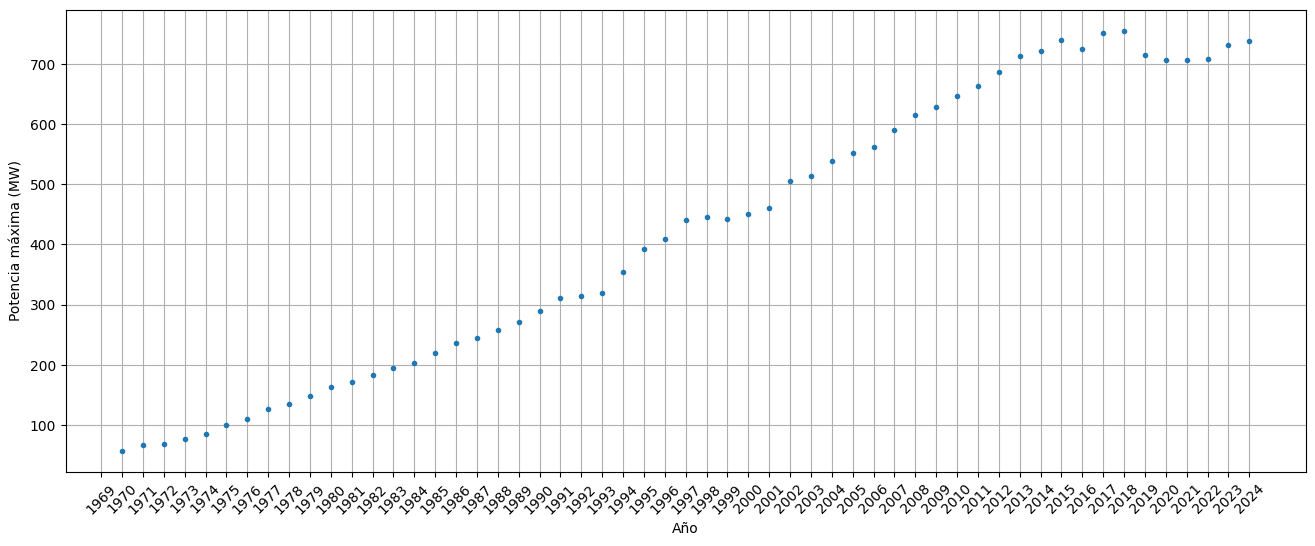

In [59]:
graficar_por_anio(df_potencia_max, "Año", "Potencia (MW)", "Potencia máxima (MW)")

In [60]:
df_potencia = melted_demanda_potencia[melted_demanda_potencia["Meses"]!="MAX AÑO"].copy()
construir_columna_fecha(df_potencia)
df_potencia = df_potencia[["Fecha", "Potencia (MW)"]].reset_index(drop=True).sort_values(by="Fecha", ascending=True)

df_potencia

,Fecha,Potencia (MW)
0,1970-01-01,53.10
1,1970-02-01,55.10
2,1970-03-01,53.55
3,1970-04-01,53.70
4,1970-05-01,55.90
...,...,...
655,2024-08-01,709.40
656,2024-09-01,725.96
657,2024-10-01,727.08
658,2024-11-01,669.32


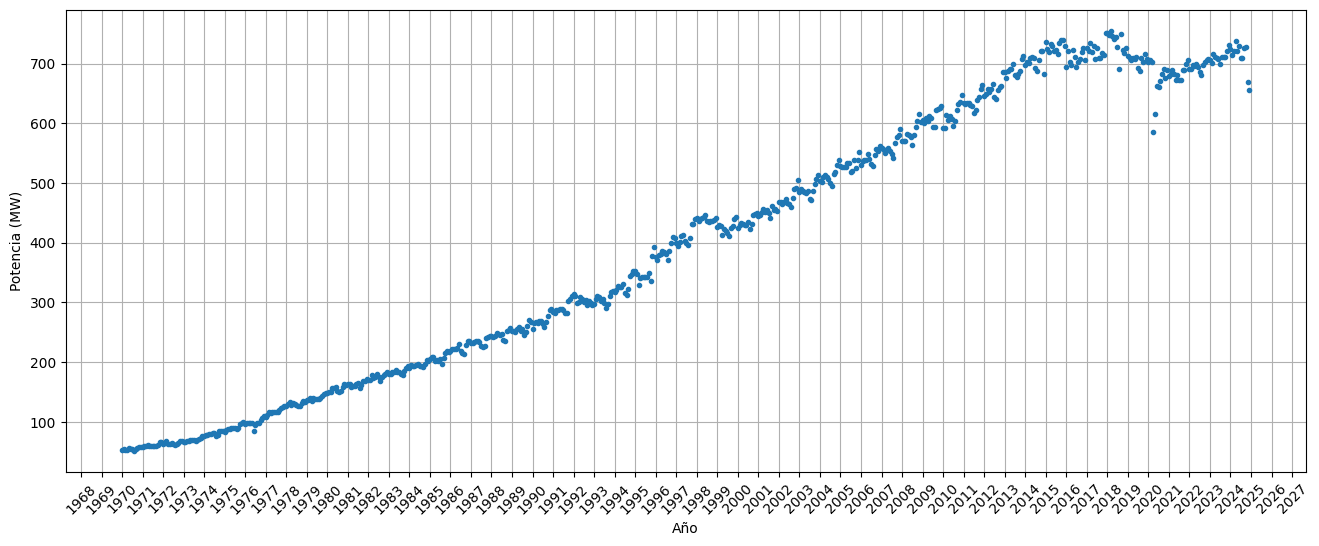

In [61]:
graficar_serie_temporal(df_potencia, "Fecha", "Potencia (MW)", "Potencia (MW)")

Graficar diagramas de cajas para los años con atípicos

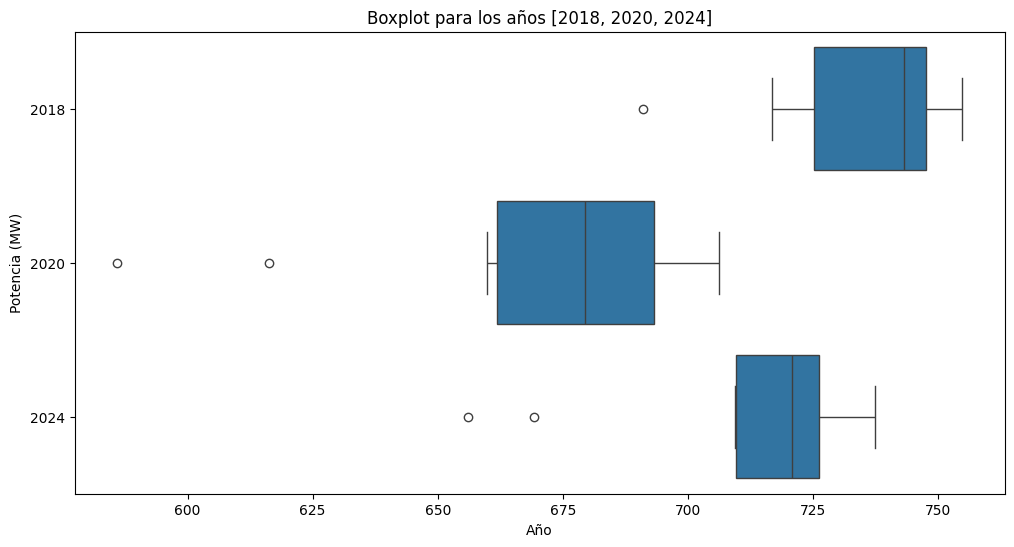

In [62]:
anios_int = [2018, 2020, 2024]
boxplot_filtrado(df_potencia, "Fecha", "Potencia (MW)", anios_int, whis=1.45)


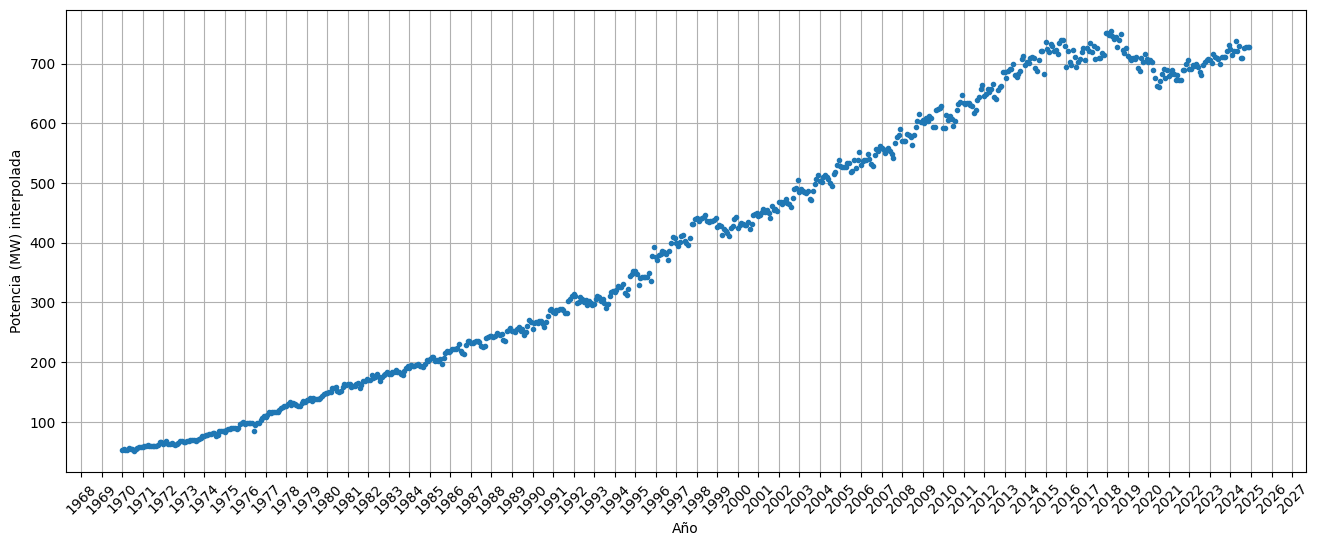

In [ ]:
anios_int = [2018, 2020, 2024]
df_potencia_interpolado = ajustar_atipicos_por_anio(df_potencia, "Potencia (MW)", anios_int)
graficar_serie_temporal(df_potencia_interpolado, "Fecha", "Potencia (MW)", "Potencia (MW) interpolada")

### Energía facturada y clientes (SISDAT)

In [64]:
df_demanda_sisdat = pd.read_excel(path_archivo, engine="openpyxl", sheet_name = "Consumo_x_grupo")
df_demanda_sisdat.head(10)

,Empresa,Año,Mes,Grupo de Consumo,Clientes,Energía Facturada (MWh),Facturación Servicio Eléctrico (USD),Recaudación Servicio Eléctrico (USD)
0,E.E. Quito,2024.0,Dic,Otros,0.0,0.00,0.00,0.00
1,E.E. Quito,2024.0,Dic,Otros,0.0,0.00,0.00,0.00
2,E.E. Quito,2024.0,Dic,Industrial,0.0,0.00,0.00,0.00
3,E.E. Quito,2024.0,Dic,Otros,0.0,0.00,0.00,0.00
4,E.E. Quito,2024.0,Dic,Otros,0.0,0.00,0.00,0.00
5,E.E. Quito,2024.0,Dic,Otros,0.0,0.00,0.00,0.00
6,E.E. Quito,2024.0,Dic,Comercial,1.0,461.52,42748.76,132454.06
7,E.E. Quito,2024.0,Dic,Otros,0.0,0.00,0.00,0.00
8,E.E. Quito,2024.0,Dic,Otros,0.0,0.00,0.00,0.00
9,E.E. Quito,2024.0,Dic,Otros,0.0,0.00,0.00,0.00


In [65]:
    # Eliminar nulos y generar columna año
df_demanda_mensual_sisdat = df_demanda_sisdat.dropna(subset=["Año"])
df_demanda_mensual_sisdat["Año"] = df_demanda_mensual_sisdat["Año"].astype('string').apply(lambda x: x.split('.')[0])

    # Construir la columna fecha de tipo datetime
construir_columna_fecha(df_demanda_mensual_sisdat)
df_demanda_mensual_sisdat = df_demanda_mensual_sisdat[['Fecha', 'Energía Facturada (MWh)']]

    # Agrupar y obtener los valores mensuales por año
df_grouped_sisdat = df_demanda_mensual_sisdat.groupby("Fecha")["Energía Facturada (MWh)"].apply(np.sum)
df_grouped_sisdat = df_grouped_sisdat.reset_index(drop=False)
df_demanda_ener_sisdat = df_grouped_sisdat[['Fecha', 'Energía Facturada (MWh)']].copy()

    # En el análisis exploratorio nos dimos cuenta que habían atípicos, se interpolarán con un nuevo valor
anios = [2017, 2022]
df_demanda_ener_sisdat_interpolado = ajustar_atipicos_por_anio(df_demanda_ener_sisdat, "Energía Facturada (MWh)", anios)

df_demanda_ener_sisdat_interpolado

,Fecha,Energía Facturada (MWh)
0,1999-01-01,160574.297024
1,1999-02-01,148753.669450
2,1999-03-01,155474.621763
3,1999-04-01,151078.075010
4,1999-05-01,157165.759077
...,...,...
307,2024-08-01,329256.727020
308,2024-09-01,326700.036860
309,2024-10-01,295880.410400
310,2024-11-01,265588.476960


In [66]:
df_demanda_sisdat.dropna(subset=["Año"], inplace=True)
df_demanda_sisdat["Año"] = df_demanda_sisdat["Año"].astype('string').apply(lambda x: x.split('.')[0])
construir_columna_fecha(df_demanda_sisdat)
df_demanda_sisdat = df_demanda_sisdat[['Fecha', 'Clientes', 'Energía Facturada (MWh)']]
df_demanda_sisdat.head(10)

,Fecha,Clientes,Energía Facturada (MWh)
0,2024-12-01,0.0,0.00
1,2024-12-01,0.0,0.00
2,2024-12-01,0.0,0.00
3,2024-12-01,0.0,0.00
4,2024-12-01,0.0,0.00
5,2024-12-01,0.0,0.00
6,2024-12-01,1.0,461.52
7,2024-12-01,0.0,0.00
8,2024-12-01,0.0,0.00
9,2024-12-01,0.0,0.00


In [67]:
df_grouped_sisdat = df_demanda_sisdat.groupby("Fecha")[["Clientes", "Energía Facturada (MWh)"]].apply(np.sum)
df_grouped_sisdat = df_grouped_sisdat.reset_index(drop=False)
df_demanda_ener_sisdat = df_grouped_sisdat[['Fecha', 'Energía Facturada (MWh)']].copy()
df_clientes_sisdat = df_grouped_sisdat[['Fecha', 'Clientes']].copy()
df_clientes_sisdat['Clientes'] = df_clientes_sisdat['Clientes'].astype("int")

In [68]:
df_demanda_ener_sisdat.head(5)

,Fecha,Energía Facturada (MWh)
0,1999-01-01,160574.297024
1,1999-02-01,148753.669450
2,1999-03-01,155474.621763
3,1999-04-01,151078.075010
4,1999-05-01,157165.759077


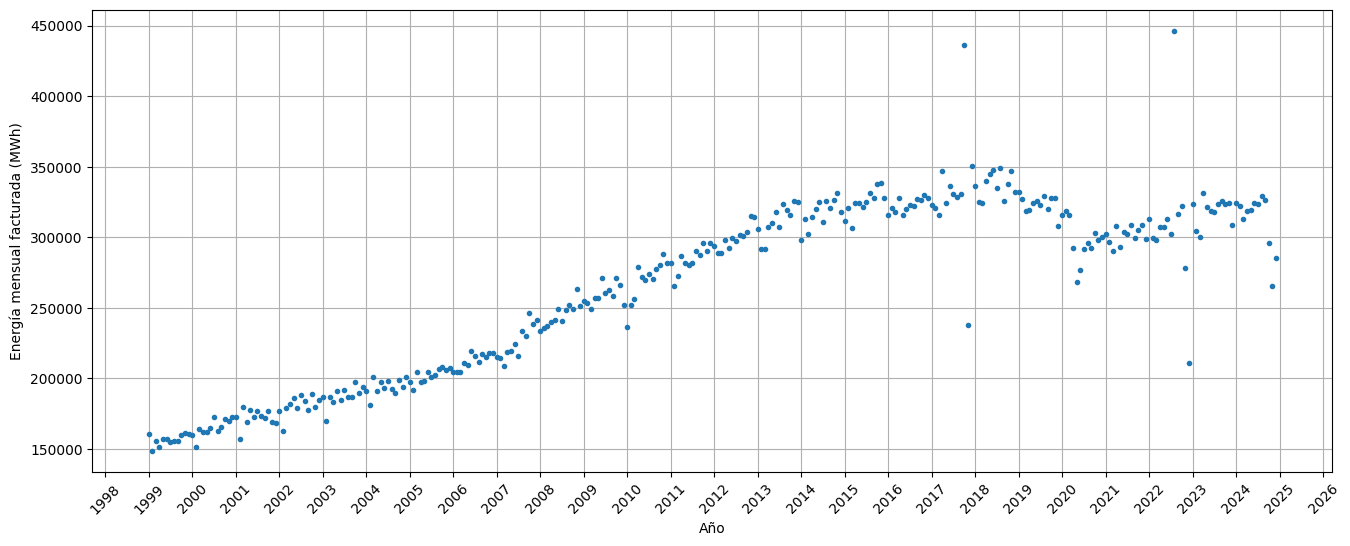

In [69]:
graficar_serie_temporal(df_demanda_ener_sisdat, "Fecha", "Energía Facturada (MWh)", y_label = 'Energía mensual facturada (MWh)')

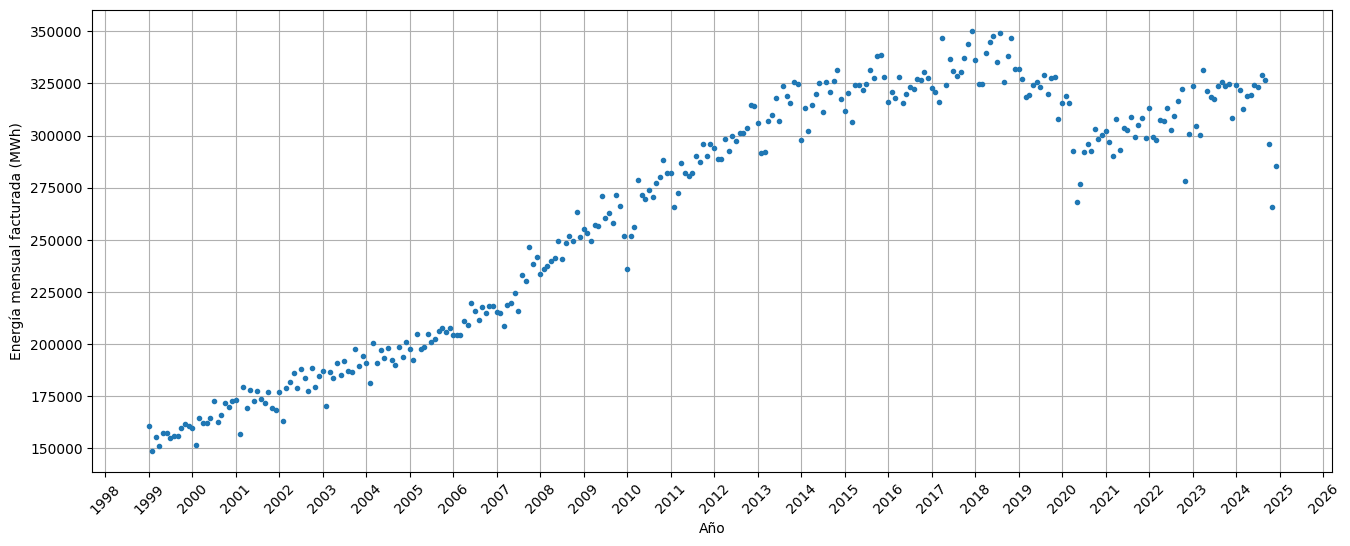

In [70]:
anios = [2017, 2022]
df_demanda_ener_sisdat_interpolado = ajustar_atipicos_por_anio(df_demanda_ener_sisdat, "Energía Facturada (MWh)", anios)


graficar_serie_temporal(df_demanda_ener_sisdat_interpolado, "Fecha", "Energía Facturada (MWh)", y_label = 'Energía mensual facturada (MWh)')

In [71]:
df_demanda_total_ener_sisdat = df_demanda_ener_sisdat.copy()
df_demanda_total_ener_sisdat['Año'] = df_demanda_total_ener_sisdat['Fecha'].astype("string").apply(lambda x: x.split('-')[0])
df_demanda_total_ener_sisdat = df_demanda_total_ener_sisdat[['Año', 'Energía Facturada (MWh)']]
df_demanda_total_ener_sisdat = df_demanda_total_ener_sisdat.groupby('Año')['Energía Facturada (MWh)'].apply(np.sum).reset_index(drop=False)
df_demanda_total_ener_sisdat['Año'] = df_demanda_total_ener_sisdat['Año'].astype("int")
df_demanda_total_ener_sisdat.head(5)

,Año,Energía Facturada (MWh)
0,1999,1.878708e+06
1,2000,1.979322e+06
2,2001,2.065354e+06
3,2002,2.167485e+06
4,2003,2.249164e+06


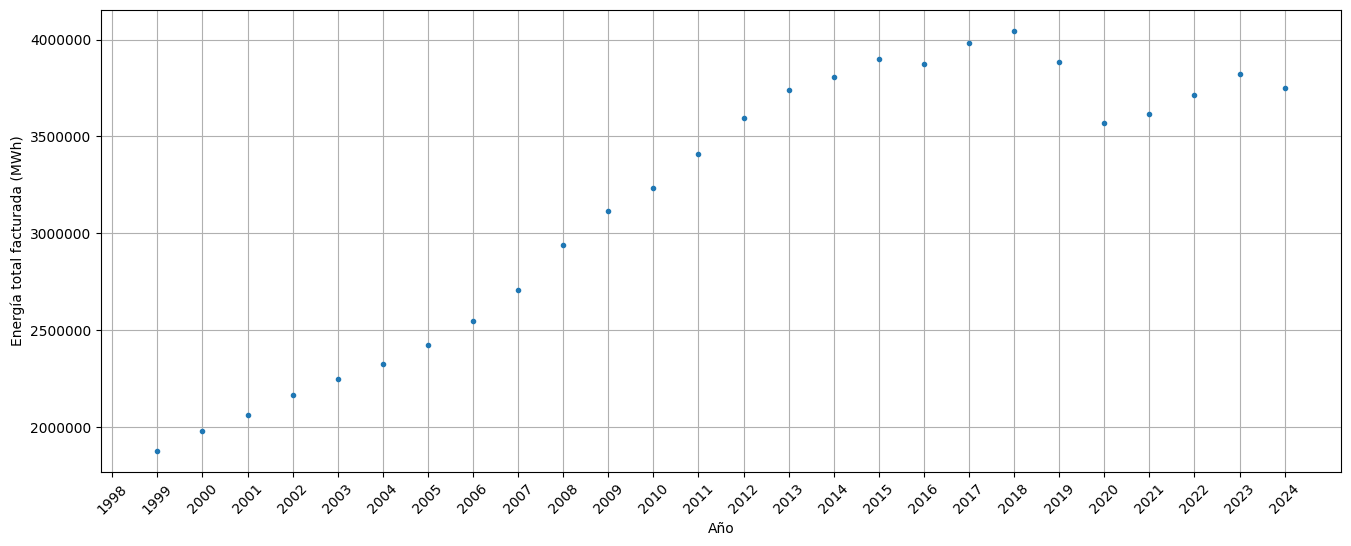

In [72]:
graficar_por_anio(df_demanda_total_ener_sisdat, "Año", "Energía Facturada (MWh)", y_label='Energía total facturada (MWh)')

In [73]:
df_clientes_sisdat.head(5)

,Fecha,Clientes
0,1999-01-01,485795
1,1999-02-01,486574
2,1999-03-01,489014
3,1999-04-01,490700
4,1999-05-01,495143


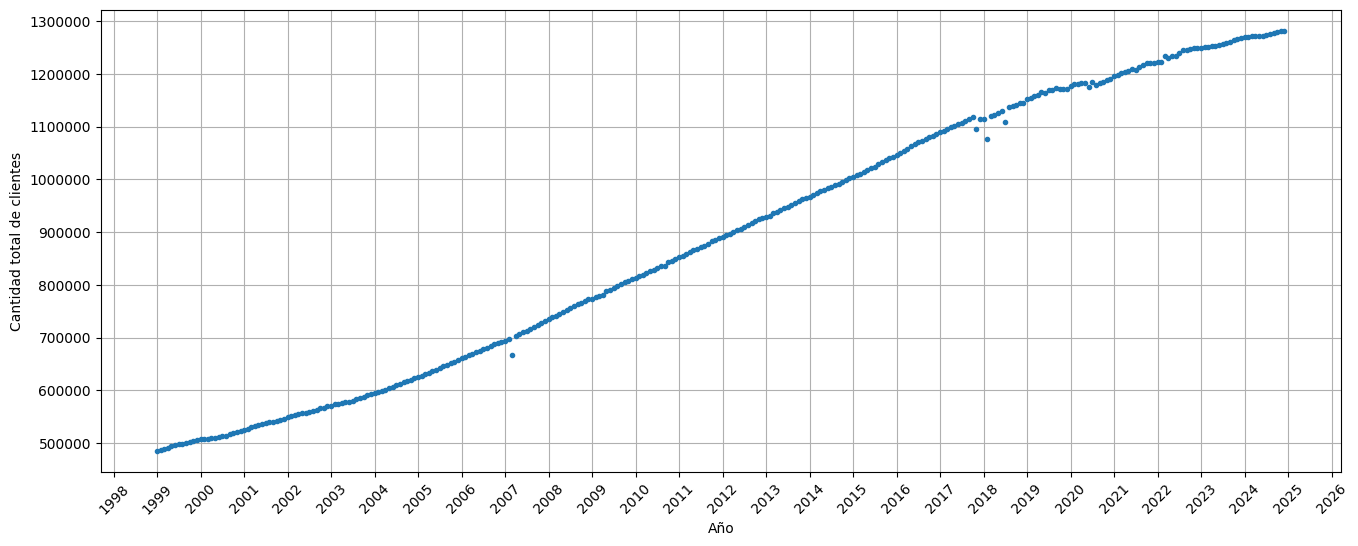

In [74]:
graficar_serie_temporal(df_clientes_sisdat, "Fecha", "Clientes", y_label="Cantidad total de clientes")

In [75]:
df_clientes_acum_anuales_sisdat = df_clientes_sisdat[df_clientes_sisdat["Fecha"].dt.month==12]
df_clientes_acum_anuales_sisdat

,Fecha,Clientes
11,1999-12-01,505433
23,2000-12-01,523128
35,2001-12-01,546574
47,2002-12-01,569897
59,2003-12-01,592760
71,2004-12-01,622680
83,2005-12-01,657932
95,2006-12-01,692109
107,2007-12-01,732245
119,2008-12-01,772566


### Energía facturada y clientes (DPT)

1. Usando la hoja 'Energia_consumida'

In [76]:
df_demanda_planificacion = pd.read_excel(path_archivo, engine="openpyxl", skiprows=3, sheet_name = 'Energia_consumida')

In [77]:
df_melted = df_demanda_planificacion.melt(id_vars=['Meses'], var_name='Mes', value_name='Valor')
df_melted.columns = ["Mes", "Año", "Energía facturada MWh"]
df_melted = df_melted[df_melted['Año']!="2023.1"]
df_melted = df_melted[df_melted['Energía facturada MWh']>0]
df_melted.dropna(subset=['Energía facturada MWh', 'Mes'], inplace=True)

df_melted

,Mes,Año,Energía facturada MWh
480,Ene,2005,1.973247e+05
481,Feb,2005,1.920325e+05
482,Mar,2005,2.046542e+05
483,Abr,2005,1.977024e+05
484,May,2005,1.984319e+05
...,...,...,...
792,Sep,2024,3.091764e+05
793,Oct,2024,2.740813e+05
794,Nov,2024,2.650531e+05
795,Dic,2024,3.043542e+05


In [78]:
df_demanda_total_ener_plan = df_melted[df_melted["Mes"]=="TOTAL"].copy()
df_demanda_total_ener_plan = df_demanda_total_ener_plan[['Año','Energía facturada MWh']]
df_demanda_total_ener_plan.head(5)

,Año,Energía facturada MWh
492,2005,2425591.759
508,2006,2547803.087
524,2007,2706560.776
540,2008,2941709.469
556,2009,3113306.444


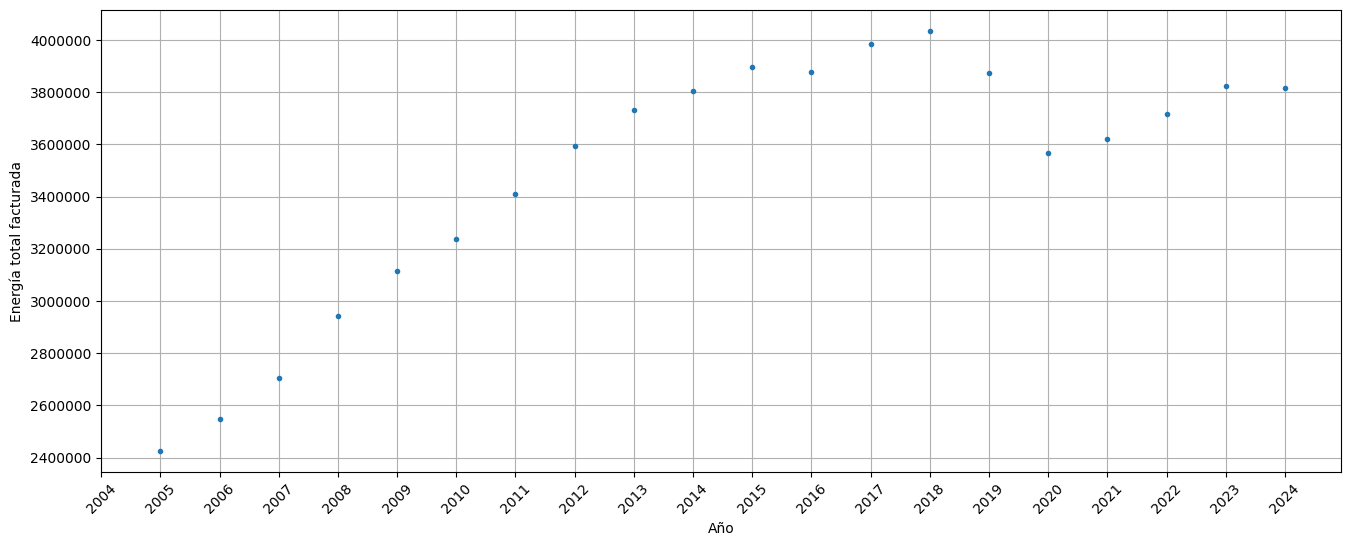

In [79]:
graficar_por_anio(df_demanda_total_ener_plan, 'Año', 'Energía facturada MWh', 'Energía total facturada')

In [80]:
df_demanda_ener_plan = df_melted[(df_melted["Mes"]!="TOTAL") & (df_melted["Mes"]!="FC (%)")].copy()
print(df_demanda_ener_plan)
construir_columna_fecha(df_demanda_ener_plan)
df_demanda_ener_plan = df_demanda_ener_plan[["Fecha", "Energía facturada MWh"]]
df_demanda_ener_plan

     Mes   Año  Energía facturada MWh
480  Ene  2005          197324.700000
481  Feb  2005          192032.477000
482  Mar  2005          204654.234000
483  Abr  2005          197702.409000
484  May  2005          198431.862000
..   ...   ...                    ...
791  Ago  2024          327560.796466
792  Sep  2024          309176.422655
793  Oct  2024          274081.274444
794  Nov  2024          265053.144670
795  Dic  2024          304354.176936

[240 rows x 3 columns]


,Fecha,Energía facturada MWh
480,2005-01-01,197324.700000
481,2005-02-01,192032.477000
482,2005-03-01,204654.234000
483,2005-04-01,197702.409000
484,2005-05-01,198431.862000
...,...,...
791,2024-08-01,327560.796466
792,2024-09-01,309176.422655
793,2024-10-01,274081.274444
794,2024-11-01,265053.144670


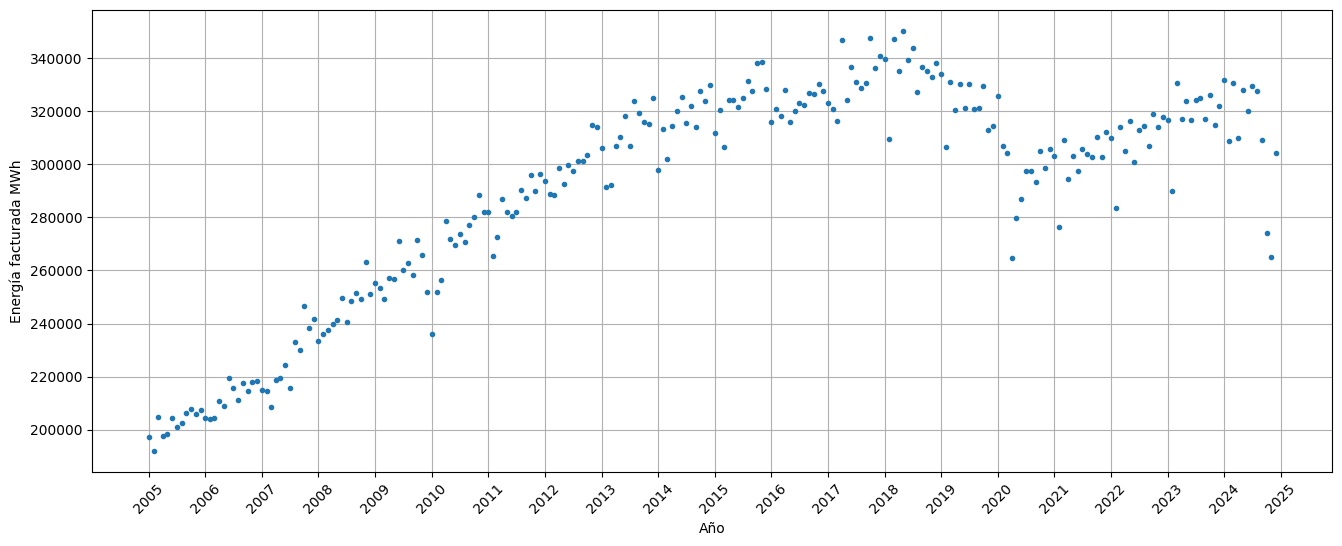

In [81]:
graficar_serie_temporal(df_demanda_ener_plan, "Fecha", "Energía facturada MWh", "Energía facturada MWh")

2. Usando la hoja 'Clientes'

In [82]:
df_demanda_planificacion = pd.read_excel(path_archivo, engine="openpyxl", skiprows=3, sheet_name = 'Clientes')
df_demanda_planificacion = df_demanda_planificacion.iloc[:12,:-27]
df_demanda_planificacion

,Etiquetas de fila,1999,2000,2001,2002,2003,2004,2005,2006,2007,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Ene,160574.297024,159894.982425,172908.985435,177159.323842,186926.274783,190989.744699,197399.324899,204317.018889,215206.588411,...,311807.70,315951.100,322951.960000,336256.771403,331789.480690,315605.508210,302126.249800,313033.16315,323569.17329,324477.50482
1,Feb,148753.66945,151693.885183,156916.476597,163032.544186,170163.212115,181109.516897,192102.440658,204281.202698,214807.867869,...,320525.20,320922.640,320869.800000,324889.550910,327192.997080,318869.550620,296982.895219,299210.44794,304823.78559,321946.63086
2,Mar,155474.621763,164336.402519,179507.034881,178856.395183,186614.859344,200680.106695,204728.974101,204391.557180,208537.598320,...,306486.94,318030.200,316155.110000,324525.230879,318689.740350,315800.014430,290107.837350,298095.52143,300214.46437,312883.61618
3,Abr,151078.07501,161938.642193,169031.873004,181689.558445,183423.684699,190881.985879,197776.474858,210825.958047,218891.334269,...,324283.80,328046.880,346678.930000,339723.459830,319290.159620,292686.479970,307747.313730,307570.68529,331563.21605,318819.03400
4,May,157165.759077,162146.742614,177699.922599,185944.187632,190892.230748,197300.540194,198507.505921,209186.736324,219563.306958,...,324047.07,315784.670,324131.060000,344880.678222,324306.269770,267986.252610,292960.098860,307048.88211,321481.44775,319635.04505
5,Jun,157103.183701,164693.018253,172585.484565,178774.595813,184933.360535,193237.306248,204578.719005,219715.609384,224468.239941,...,321631.25,319929.157,336729.630000,348010.971940,325903.274699,276979.591540,303430.023770,313092.13057,318408.38330,324302.63900
6,Jul,154677.786646,172536.394157,177207.132941,188177.863362,191813.313285,198284.842058,201059.814451,215685.887926,215955.881502,...,324893.97,323216.530,331062.600951,335245.484240,323177.806690,291892.458750,302645.730230,302605.86823,317735.35510,323420.95398
7,Ago,155937.775266,162495.560704,173560.370973,183791.240327,186947.277059,192401.570202,202488.991100,211408.395204,233282.923268,...,331315.36,322405.340,328777.420000,349218.807460,329161.321910,296040.938540,308881.738870,446441.38209,323645.60696,329256.72702
8,Sep,155696.897982,165729.197405,171618.011015,177404.308254,186536.713736,189928.005989,206437.845810,217518.044349,230116.296185,...,327725.93,326985.550,330684.144190,325716.835660,319783.878610,292589.673330,299389.908000,316576.22251,325595.44782,326700.03686
9,Oct,159851.642,171474.329799,176780.207924,188681.769264,197358.454145,198755.582855,207768.321110,214833.902072,246596.112899,...,337955.46,326476.650,436003.787263,338008.249370,327548.543330,303220.284240,305073.862620,322178.78469,323651.87414,295880.41040


In [83]:
melted_demandas_mensuales_dpt = df_demanda_planificacion.melt(id_vars=['Etiquetas de fila'], var_name='Mes', value_name='Valor')
melted_demandas_mensuales_dpt.columns = ["Mes", "Año", "Energía Facturada (MWh)"]
construir_columna_fecha(melted_demandas_mensuales_dpt)
melted_demandas_mensuales_dpt = melted_demandas_mensuales_dpt[["Fecha", "Energía Facturada (MWh)"]]
melted_demandas_mensuales_dpt.to_csv("Demandas_dpt.csv", index=False)
anios = [2017, 2022]
melted_demandas_mensuales_dpt = ajustar_atipicos_por_anio(melted_demandas_mensuales_dpt, "Energía Facturada (MWh)", anios)
melted_demandas_mensuales_dpt

,Fecha,Energía Facturada (MWh)
0,1999-01-01,160574.297024
1,1999-02-01,148753.66945
2,1999-03-01,155474.621763
3,1999-04-01,151078.07501
4,1999-05-01,157165.759077
...,...,...
307,2024-08-01,329256.72702
308,2024-09-01,326700.03686
309,2024-10-01,295880.4104
310,2024-11-01,265588.47696


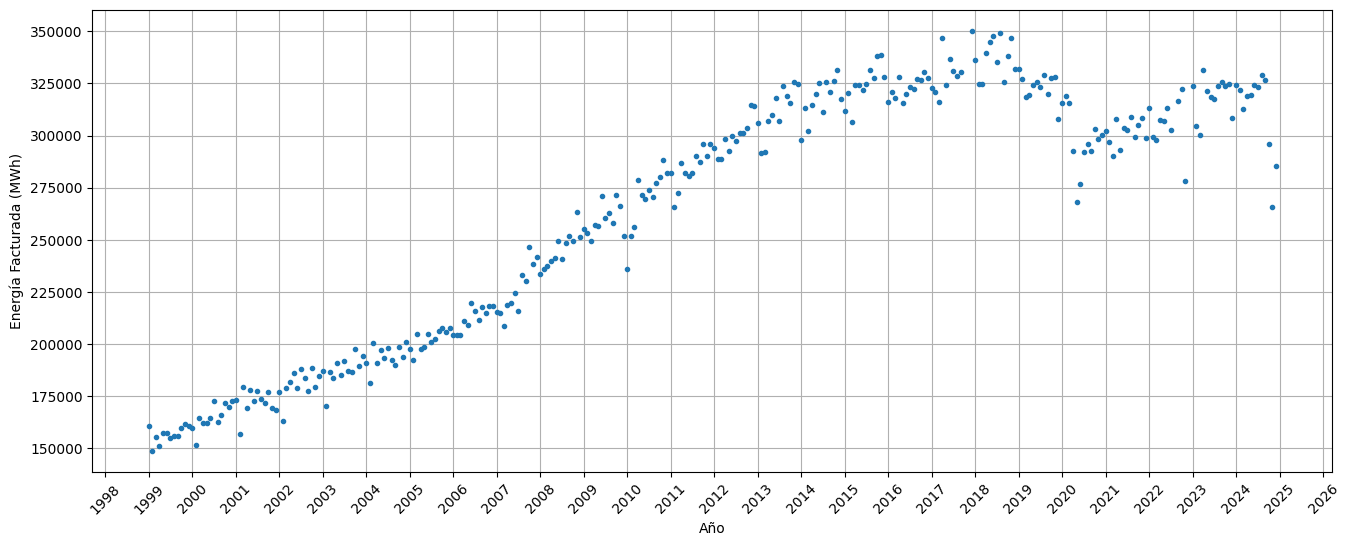

In [84]:
graficar_serie_temporal(melted_demandas_mensuales_dpt, "Fecha", "Energía Facturada (MWh)", "Energía Facturada (MWh)")

In [85]:
df_total_clientes_plan = pd.read_excel(path_archivo, engine="openpyxl", sheet_name="Cantidad_clientes_anual",skiprows=0, usecols=["Unnamed: 0", "TOTAL"])
df_total_clientes_plan.head(5)

,Unnamed: 0,TOTAL
0,NaN,#
1,1983.0,NaN
2,1984.0,219659
3,1985.0,233048
4,1986.0,246277


In [86]:
df_total_clientes_plan = df_total_clientes_plan[["Unnamed: 0", "TOTAL"]]
df_total_clientes_plan = df_total_clientes_plan[df_total_clientes_plan["Unnamed: 0"]>=1984]
df_total_clientes_plan.columns = ["Año", "Clientes"]
df_total_clientes_plan["Año"] = df_total_clientes_plan["Año"].astype("int")
df_total_clientes_plan.head(5)

,Año,Clientes
2,1984,219659
3,1985,233048
4,1986,246277
5,1987,259236
6,1988,273744


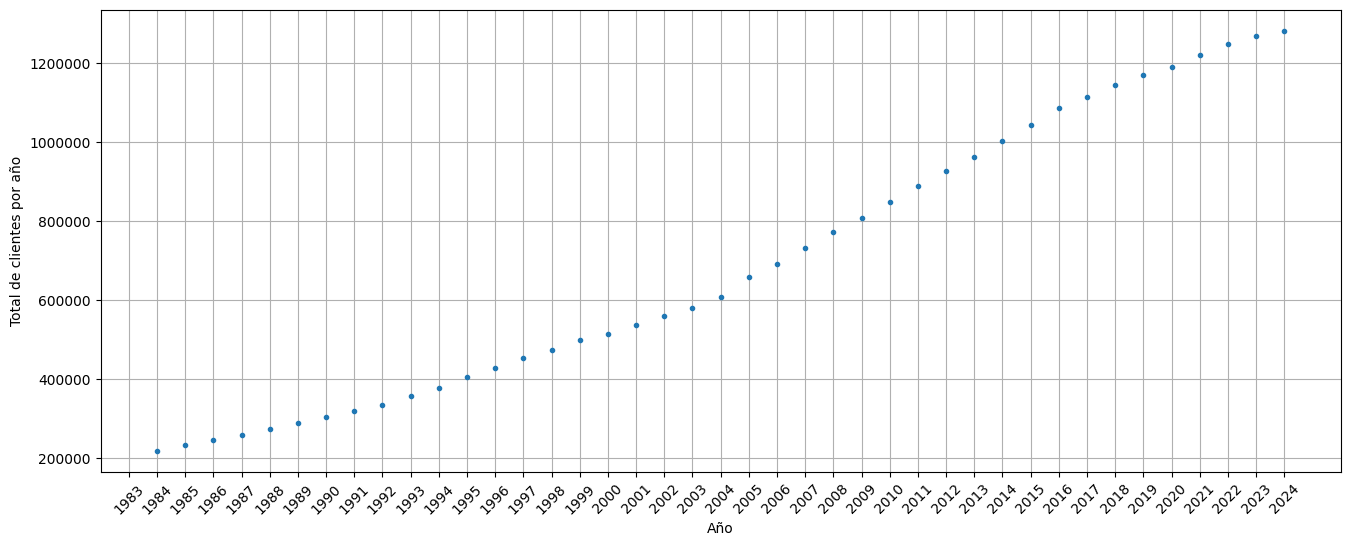

In [87]:
graficar_por_anio(df_total_clientes_plan, "Año", "Clientes", "Total de clientes por año")

### Clientes mensuales DPT

In [88]:
clientes_mensuales_dpt = pd.read_excel(path_archivo, engine="openpyxl", sheet_name="Clientes",skiprows=23)
clientes_mensuales_dpt = clientes_mensuales_dpt.dropna(subset=["Etiquetas de fila"])
clientes_mensuales_dpt = clientes_mensuales_dpt.iloc[:-1,:-27]
clientes_mensuales_dpt

,Etiquetas de fila,1999,2000,2001,2002,2003,2004,2005,2006,2007,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Ene,485795.0,507340.0,525599.0,549648.0,571464.0,595186.0,625434.0,660897.0,694192.0,...,1004316.0,1046918.0,1089570.0,1115266.0,1151738.0,1177433.0,1195203.0,1223390.0,1249308.0,1269016.0
1,Feb,486574.0,508189.0,527048.0,551314.0,573504.0,596831.0,627958.0,663492.0,697133.0,...,1007422.0,1049683.0,1092580.0,1076260.0,1154772.0,1180665.0,1197407.0,1223247.0,1250181.0,1270793.0
2,Mar,489014.0,508522.0,530575.0,554113.0,575158.0,599245.0,630512.0,666954.0,666954.0,...,1010363.0,1052864.0,1095248.0,1119739.0,1158399.0,1180139.0,1201663.0,1234031.0,1251231.0,1271086.0
3,Abr,490700.0,509657.0,532704.0,554789.0,577128.0,601734.0,633724.0,669587.0,703284.0,...,1013443.0,1058033.0,1098694.0,1122610.0,1159809.0,1183617.0,1202652.0,1230954.0,1251894.0,1271241.0
4,May,495143.0,510828.0,535265.0,556748.0,578484.0,604762.0,636168.0,672168.0,707217.0,...,1017626.0,1064151.0,1100881.0,1126115.0,1164898.0,1183159.0,1205183.0,1233674.0,1253307.0,1271951.0
5,Jun,496344.0,512595.0,536639.0,557980.0,578375.0,607170.0,639198.0,674750.0,710528.0,...,1021165.0,1067757.0,1104557.0,1129231.0,1163766.0,1174236.0,1208287.0,1233840.0,1255109.0,1271817.0
6,Jul,498215.0,513162.0,538018.0,559651.0,580790.0,610201.0,642823.0,677621.0,713620.0,...,1024307.0,1070236.0,1107348.0,1108031.0,1169348.0,1184367.0,1207887.0,1239601.0,1256897.0,1273166.0
7,Ago,498994.0,514477.0,539368.0,561253.0,583722.0,612567.0,645689.0,681194.0,716589.0,...,1028648.0,1072994.0,1110641.0,1137082.0,1170318.0,1178237.0,1212433.0,1244525.0,1259167.0,1275124.0
8,Sep,501062.0,516612.0,540838.0,563853.0,585829.0,616386.0,648348.0,684783.0,720377.0,...,1033163.0,1076386.0,1113985.0,1138607.0,1172774.0,1182675.0,1216006.0,1245948.0,1261143.0,1276870.0
9,Oct,501591.0,518949.0,542745.0,566040.0,588333.0,618174.0,651552.0,687430.0,723715.0,...,1036339.0,1079871.0,1117442.0,1140639.0,1171734.0,1184594.0,1219828.0,1246833.0,1264435.0,1278901.0


In [89]:
melted_clientes_mensuales_dpt = clientes_mensuales_dpt.melt(id_vars=['Etiquetas de fila'], var_name='Mes', value_name='Valor')
melted_clientes_mensuales_dpt.columns = ["Mes", "Año", "Clientes"]
construir_columna_fecha(melted_clientes_mensuales_dpt)
melted_clientes_mensuales_dpt = melted_clientes_mensuales_dpt[["Fecha", "Clientes"]]
melted_clientes_mensuales_dpt["Clientes"] = melted_clientes_mensuales_dpt["Clientes"].astype("int")
melted_clientes_mensuales_dpt

,Fecha,Clientes
0,1999-01-01,485795
1,1999-02-01,486574
2,1999-03-01,489014
3,1999-04-01,490700
4,1999-05-01,495143
...,...,...
307,2024-08-01,1275124
308,2024-09-01,1276870
309,2024-10-01,1278901
310,2024-11-01,1281025


### Desagregación para tablas donde solo se tienen totales

In [90]:
df_desagregado_clientes_dpt = \
    desagregar_demanda_mensual(df_clientes_sisdat, df_total_clientes_plan, nombre_col_valor="Clientes", acumulada=True)
df_desagregado_clientes_dpt["Clientes"] = df_desagregado_clientes_dpt["Clientes"].apply(np.round).astype("int")
construir_columna_fecha(df_desagregado_clientes_dpt)
df_desagregado_clientes_dpt = df_desagregado_clientes_dpt[["Fecha", "Clientes"]]
df_desagregado_clientes_dpt.iloc[-13:]

,Fecha,Clientes
479,2023-12-01,1267912
480,2024-01-01,1235013
481,2024-02-01,1237311
482,2024-03-01,1243274
483,2024-04-01,1247857
484,2024-05-01,1251908
485,2024-06-01,1255922
486,2024-07-01,1258834
487,2024-08-01,1264560
488,2024-09-01,1269287


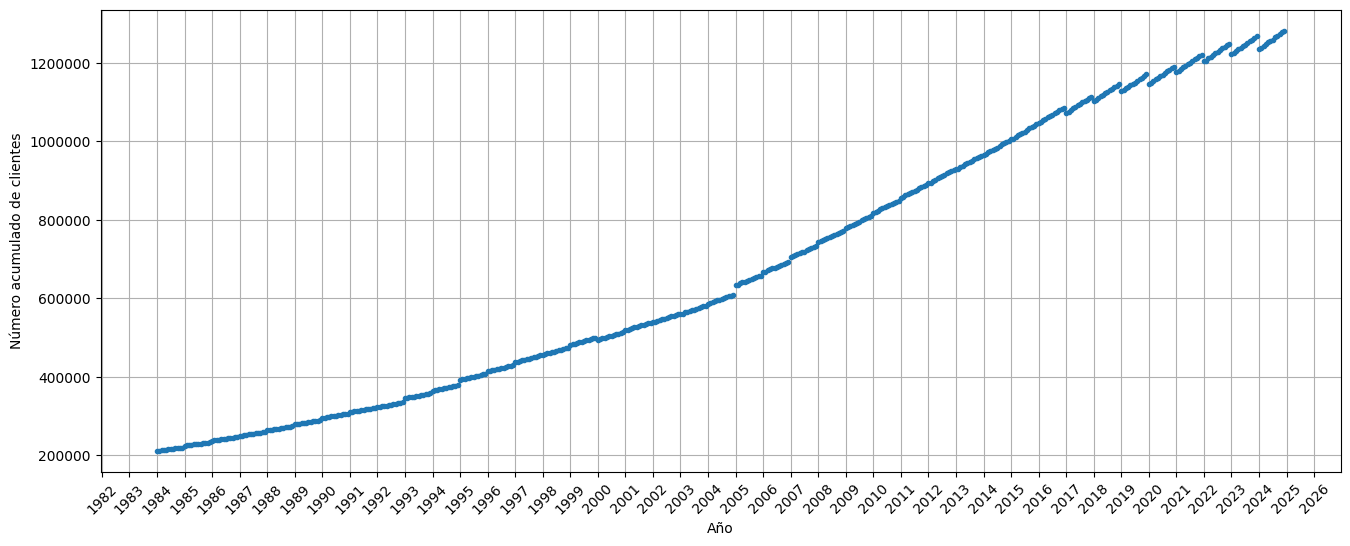

In [91]:
graficar_serie_temporal(df_desagregado_clientes_dpt, "Fecha", "Clientes", y_label="Número acumulado de clientes")

In [92]:
df_demanda_total_ener_plan_hist = pd.read_excel(path_archivo, engine="openpyxl", sheet_name="Mwh-facturados",skiprows=4, nrows=60)
df_demanda_total_ener_plan_hist.head(5)

,Unnamed: 0,MWh,RESIDENCIAL,%,COMERCIAL,%.1,INDUSTRIAL,%.2,No Regul.,%.3,AP,%.4,OTROS,%.5,TOTAL,OTROS INC AP,%.6,Incremento Total,Tasa Anual (%)
0,NaN,1966,60621.135,42.568715,19377.862,13.607312,35410.986,24.865918,NaN,NaN,NaN,NaN,NaN,NaN,142407.717,26997.734,18.958055,NaN,NaN
1,NaN,1967,67224.494,42.132997,21586.853,13.529575,43255.417,27.110362,NaN,NaN,NaN,NaN,NaN,NaN,159553.079,27486.315,17.227066,NaN,0.120396
2,NaN,1968,74505.397,42.045836,23229.837,13.109358,49063.997,27.688420,NaN,NaN,NaN,NaN,NaN,NaN,177200.419,30401.188,17.156386,NaN,0.110605
3,NaN,1969,84638.441,42.476621,25476.687,12.785722,51399.673,25.795424,NaN,NaN,NaN,NaN,NaN,NaN,199258.882,37744.081,18.942233,NaN,0.124483
4,NaN,1970,91935.193,43.172949,28545.676,13.405106,56529.229,26.546238,NaN,NaN,NaN,NaN,NaN,NaN,212946.292,35936.194,16.875708,NaN,0.068692


In [93]:
df_demanda_total_ener_plan_hist = df_demanda_total_ener_plan_hist[['MWh', 'TOTAL']]
df_demanda_total_ener_plan_hist['MWh'] = df_demanda_total_ener_plan_hist['MWh'].astype("int")
df_demanda_total_ener_plan_hist = df_demanda_total_ener_plan_hist[df_demanda_total_ener_plan_hist['MWh']<=2023]
df_demanda_total_ener_plan_hist.columns = ['Año', 'Energía facturada MWh']
df_demanda_total_ener_plan_hist['Año'] = df_demanda_total_ener_plan_hist['Año'].astype("int")
df_demanda_total_ener_plan_hist.head(5)

,Año,Energía facturada MWh
0,1966,142407.717
1,1967,159553.079
2,1968,177200.419
3,1969,199258.882
4,1970,212946.292


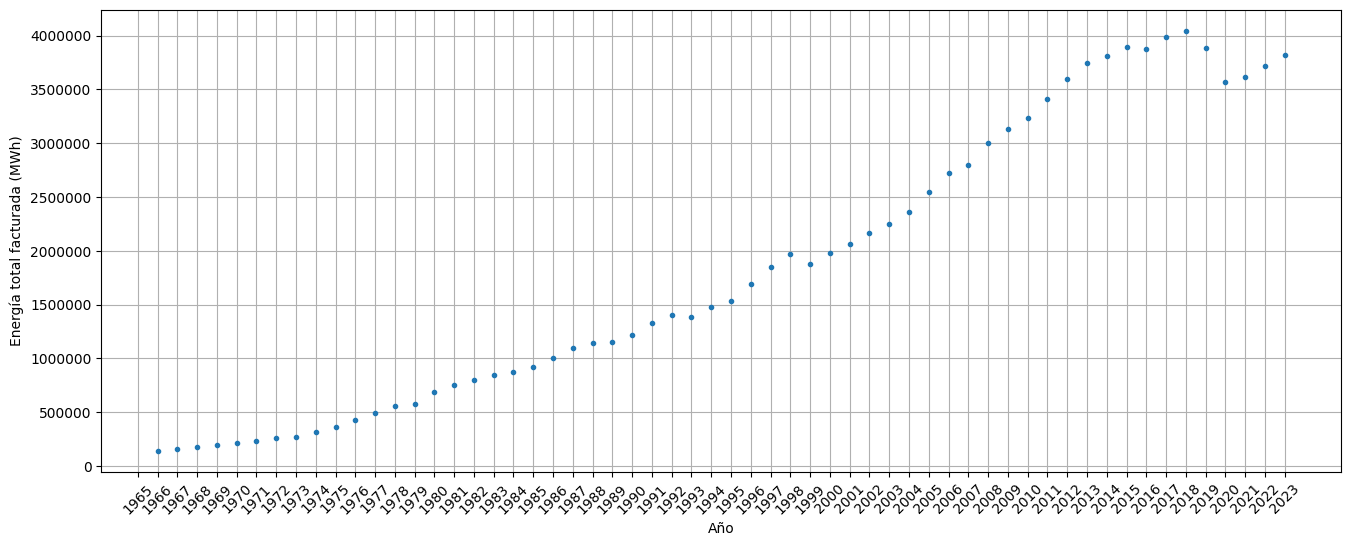

In [94]:
graficar_por_anio(df_demanda_total_ener_plan_hist, "Año", "Energía facturada MWh", "Energía total facturada (MWh)")

In [95]:
df_desagregado_demanda_dpt_cn = \
    desagregar_demanda_mensual(df_demanda_ener_plan[df_demanda_ener_plan['Fecha']<datetime(2015,1,1)],
                               df_demanda_total_ener_plan_hist[(df_demanda_total_ener_plan_hist['Año']<2018) | (df_demanda_total_ener_plan_hist['Año']>2020)],
                               nombre_col_valor="Energía facturada MWh",
                               acumulada=False)

df_desagregado_demanda_dpt_ca = \
    desagregar_demanda_mensual(df_demanda_ener_plan[(df_demanda_ener_plan['Fecha']>datetime(2017,12,1)) & (df_demanda_ener_plan['Fecha']<datetime(2020,12,1))],
                               df_demanda_total_ener_plan_hist[(df_demanda_total_ener_plan_hist['Año']>=2018) & (df_demanda_total_ener_plan_hist['Año']<=2020)],
                               nombre_col_valor="Energía facturada MWh",
                               acumulada=False)

df_desagregado_demanda_dpt = pd.concat([df_desagregado_demanda_dpt_cn, df_desagregado_demanda_dpt_ca])

construir_columna_fecha(df_desagregado_demanda_dpt)
df_desagregado_demanda_dpt = df_desagregado_demanda_dpt[["Fecha", "Energía facturada MWh"]]
df_desagregado_demanda_dpt.head(5)

Mes
1     0.080757
2     0.079745
3     0.079988
4     0.082650
5     0.082275
6     0.084560
7     0.082812
8     0.084436
9     0.085037
10    0.085871
11    0.085522
12    0.086736
Name: porcentaje_mensual, dtype: float64
Mes
1     0.086297
2     0.079159
3     0.086007
4     0.082747
5     0.085837
6     0.084041
7     0.085249
8     0.082825
9     0.083395
10    0.085065
11    0.082535
12    0.082491
Name: porcentaje_mensual, dtype: float64


,Fecha,Energía facturada MWh
0,1966-01-01,11495.868249
1,1966-02-01,11351.687244
2,1966-03-01,11386.355234
3,1966-04-01,11765.340210
4,1966-05-01,11711.991366


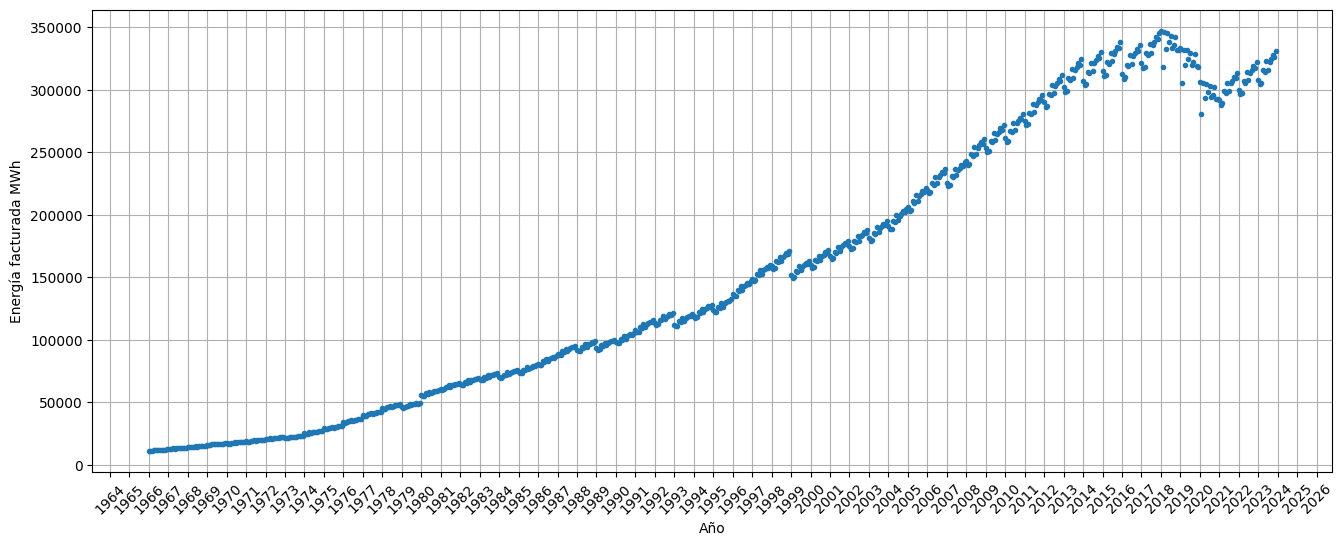

In [96]:
graficar_serie_temporal(df_desagregado_demanda_dpt, "Fecha", "Energía facturada MWh", y_label="Energía facturada MWh")

### Combinando los dataframes

In [97]:
# Hacemos merge de df1 con df2 (left join)
df_demanda_combinado = pd.merge(df_desagregado_demanda_dpt, df_demanda_ener_plan, on='Fecha', how='left', suffixes=('_tot', '_men'))

# Creamos la columna final:
# Si 'valor_df2' es no nulo, la usamos; si no, usamos 'valor_df1'
df_demanda_combinado['Energía facturada MWh'] = df_demanda_combinado['Energía facturada MWh_men'].combine_first(df_demanda_combinado['Energía facturada MWh_tot'])

In [98]:
df_demanda_combinado

,Fecha,Energía facturada MWh_tot,Energía facturada MWh_men,Energía facturada MWh
0,1966-01-01,11495.868249,NaN,11495.868249
1,1966-02-01,11351.687244,NaN,11351.687244
2,1966-03-01,11386.355234,NaN,11386.355234
3,1966-04-01,11765.340210,NaN,11765.340210
4,1966-05-01,11711.991366,NaN,11711.991366
...,...,...,...,...
691,2020-08-01,294011.954024,297285.762620,297285.762620
692,2020-09-01,296049.317008,293316.561908,293316.561908
693,2020-10-01,302009.819588,305107.125665,305107.125665
694,2020-11-01,292976.212170,298482.622406,298482.622406


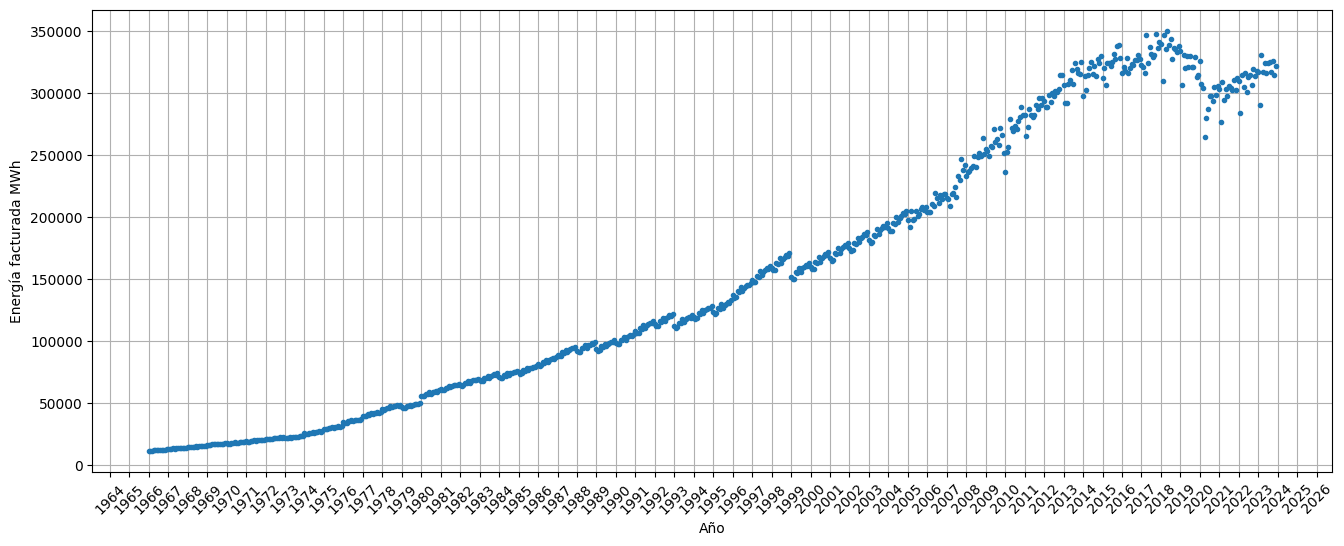

In [99]:
graficar_serie_temporal(df_demanda_combinado, 'Fecha','Energía facturada MWh', 'Energía facturada MWh')

In [100]:
# Hacemos merge de df1 con df2 (left join)
df_clientes_combinado = pd.merge(df_desagregado_clientes_dpt, df_clientes_sisdat, on='Fecha', how='left', suffixes=('_tot', '_men'))

# Creamos la columna final:
# Si 'valor_df2' es no nulo, la usamos; si no, usamos 'valor_df1'
df_clientes_combinado['Clientes'] = df_clientes_combinado['Clientes_men'].combine_first(df_clientes_combinado['Clientes_tot'])

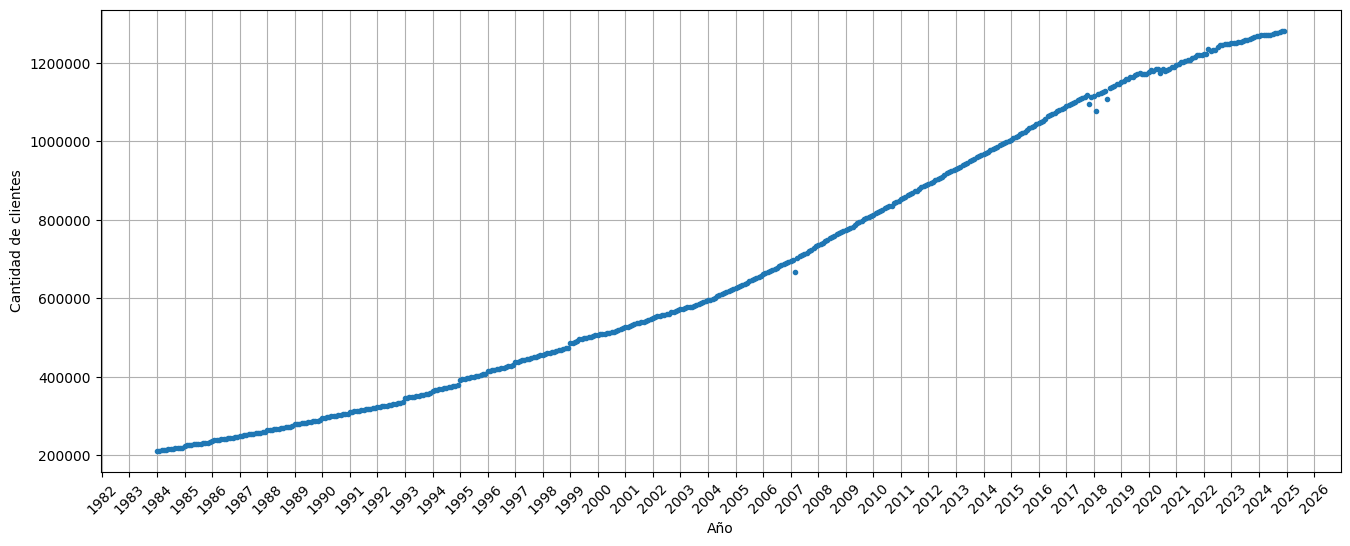

In [101]:
graficar_serie_temporal(df_clientes_combinado, 'Fecha','Clientes', 'Cantidad de clientes')

Mapa de calor para identificar correlación entre variables

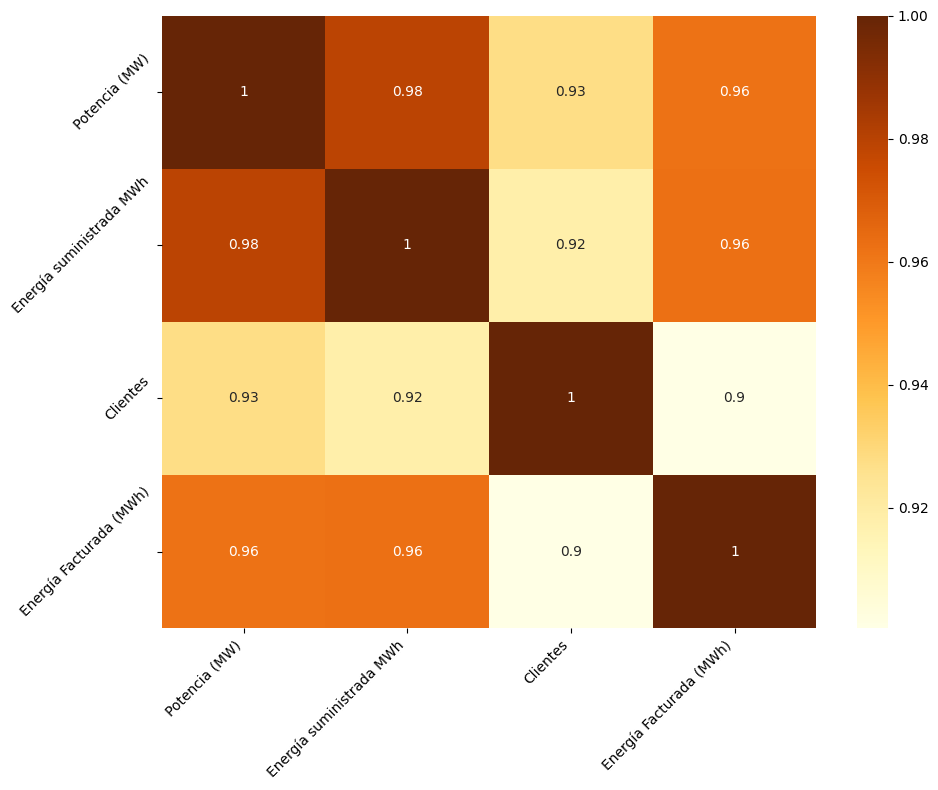

In [130]:
df_merged_corr = df_potencia.merge(df_ener_suministrada, how='inner', on='Fecha') \
                            .merge(df_clientes_sisdat, how='inner', on='Fecha') \
                            .merge(df_demanda_ener_sisdat, how='inner', on='Fecha')

matriz_corr = df_merged_corr.drop(columns=['Fecha']).corr()

plt.figure(figsize=(10,8))  # opcional, para más espacio
ax = sns.heatmap(matriz_corr, cmap='YlOrBr', annot=True)

# rotar las etiquetas
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [116]:
df_merged_corr.drop(columns=["Fecha"])

,Potencia (MW),Energía suministrada MWh,Clientes,Energía Facturada (MWh)
0,426.58,190480.100000,485795,160574.297024
1,429.20,175797.800000,486574,148753.669450
2,427.15,187543.800000,489014,155474.621763
3,412.80,181788.300000,490700,151078.075010
4,422.32,187739.800000,495143,157165.759077
...,...,...,...,...
307,709.40,354791.868251,1275124,329256.727020
308,725.96,335115.003816,1276870,326700.036860
309,727.08,285374.699241,1278901,295880.410400
310,669.32,278376.180328,1281025,265588.476960


In [104]:
df_ener_suministrada

,Fecha,Energía suministrada MWh
0,1975-01-01,35864.100000
1,1975-02-01,33732.000000
2,1975-03-01,36944.600000
3,1975-04-01,37317.700000
4,1975-05-01,38220.500000
...,...,...
595,2024-08-01,354791.868251
596,2024-09-01,335115.003816
597,2024-10-01,285374.699241
598,2024-11-01,278376.180328
